In [1]:
import numpy as np
from scipy.special import jacobi, hyp1f1, gamma
from matplotlib import pyplot as plt
import sympy

from pywave.utils.jacobi_polynomials import JacobiPolynomials

- Orthogonality https://functions.wolfram.com/Polynomials/JacobiP/21/02/01/0001/
  \begin{align}
  h_m\delta_{mn} 
  &= \int_{-1}^1(1-t)^{\alpha}(1+t)^\beta 
  P_m^{(\alpha,\beta)}(t)P_n^{(\alpha,\beta)}(t)dt\\
  &=\frac
  {2^{\alpha+\beta+1}\Gamma(\alpha+m+1)\Gamma(\beta+m+1)}
  {m!(\alpha+\beta+2m+1)\Gamma(\alpha+\beta+m+1)}\delta_{mn}
  \end{align}
- Recurrence relation
  https://en.wikipedia.org/wiki/Jacobi_polynomials#Recurrence_relations
- Roots from companion matrix
  https://core.ac.uk/download/pdf/82721955.pdf
- Quadrature weights from
  https://en.wikipedia.org/wiki/Gauss%E2%80%93Jacobi_quadrature
  - General formula for Gaussian quadrature weights
  https://en.wikipedia.org/wiki/Gaussian_quadrature#General_formula_for_the_weights

## Test and time calculation of the polynomials
Compare to `scipy.spatial.jacobi`

In [2]:
alf = 1.5 #.25
bet = .5 #.75
max_deg = 10
jp = JacobiPolynomials(alpha=alf, beta=bet, max_degree=max_deg)
# t = np.linspace(-1,1,15)
t,_,_ = jp.quad_points_weights()

In [3]:
%time pn = jp.get_polys(t)

CPU times: user 0 ns, sys: 661 µs, total: 661 µs
Wall time: 513 µs


In [4]:
%%time
pn2 = np.ones((len(t), max_deg+1))
for n in range(1, max_deg + 1):
    pn2[:,n] = jacobi(n, alf, bet)(t)

CPU times: user 4.45 ms, sys: 118 µs, total: 4.57 ms
Wall time: 3.59 ms


In [5]:
n = 5
print(np.array([pn[:,n],pn2[:,n]]).T)

[[-1.69281661 -1.69281661]
 [ 0.09954254  0.09954254]
 [ 0.64874116  0.64874116]
 [-0.12383926 -0.12383926]
 [-0.52515133 -0.52515133]
 [ 0.1841687   0.1841687 ]
 [ 0.62799587  0.62799587]
 [-0.35265085 -0.35265085]
 [-1.18264868 -1.18264868]
 [ 1.07753743  1.07753743]
 [ 6.64579517  6.64579517]]


## Test quadrature scheme
### Default interval

In [6]:
t = sympy.Symbol('t')
ig = sympy.Integral((1-t)**1.5*(1+t)**.5*(t**2), (t,-1,1))
ig

Integral(t**2*(1 - t)**1.5*(t + 1)**0.5, (t, -1, 1))

In [7]:
ig.evalf()

0.392699081698724

In [8]:
jp = JacobiPolynomials(alpha=1.5, beta=.5, max_degree=50)
x, w, hm = jp.quad_points_weights()
f = x**2
np.sum(w*f)

0.3926990816987234

### Arbitrary interval

In [9]:
ig = sympy.Integral((2.1-t)**1.5*(1.2+t)**.5*(t**2), (t,-1.2,2.1))
ig

Integral(3.33364665194138*t**2*(1 - 0.476190476190476*t)**1.5*(0.833333333333333*t + 1)**0.5, (t, -1.2, 2.1))

In [10]:
ig.evalf()

3.61189925946462 + 0.e-25*I

In [11]:
jp = JacobiPolynomials(alpha=1.5, beta=.5, a=-1.2, b=2.1, max_degree=50)
x, w, hm = jp.quad_points_weights()
f = x**2
np.sum(w*f)

3.61189925946461

## Test orthogonality
### Default interval

In [12]:
max_deg = 13
jp = JacobiPolynomials(alpha=1.5, beta=.5, max_degree=max_deg)
x, w, hm = jp.quad_points_weights()
pm = jp.get_polys(x)
for i in range(max_deg):
    f = jacobi(i,1.5,.5)(x)
    g = pm[:,i]
    print(i, np.sum(w*f), 0, np.sum(w*f**2), hm[i], np.sum(w*g**2), pm[:,i].dot(w*pm[:,i]))

0 1.5707963267948963 0 1.5707963267948963 1.5707963267948966 1.5707963267948963 1.5707963267948966
1 4.551480720094148e-16 0 1.1780972450961726 1.1780972450961724 1.1780972450961726 1.1780972450961724
2 -2.177077962350893e-16 0 0.9203884727313841 0.9203884727313847 0.9203884727313842 0.920388472731384
3 4.49293380277993e-16 0 0.7516505860639633 0.7516505860639642 0.751650586063963 0.7516505860639628
4 -7.450637329320386e-16 0 0.6342051819914697 0.6342051819914698 0.6342051819914694 0.6342051819914694
5 1.2932363513407097e-15 0 0.5481344787211995 0.5481344787211989 0.5481344787211994 0.5481344787211992
6 -1.0685896612017132e-15 0 0.48247253595772305 0.482472535957722 0.48247253595772277 0.4824725359577227
7 8.257283745649602e-16 0 0.43077904996225236 0.4307790499622518 0.4307790499622522 0.43077904996225225
8 3.972516759986888e-16 0 0.38904732949715864 0.38904732949715864 0.38904732949715853 0.3890473294971585
9 -1.4424225702747151e-15 0 0.35466183320321815 0.35466183320321787 0.3546618

In [13]:
ip = np.diag(1/hm).dot(pm.T).dot(np.diag(w)).dot(pm)
np.diag(ip), ip[-1]

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([-1.38864614e-15,  3.66216650e-16, -8.39659139e-16,  2.37730442e-16,
         1.10780088e-15,  4.99352583e-16,  2.70366217e-15,  7.02570331e-16,
         1.51279347e-15, -5.58682402e-16,  1.51606935e-15, -2.94919137e-16,
         1.30915790e-15,  1.00000000e+00]))

### Arbitrary interval

In [14]:
a = -1.2
b = 2.1
max_deg = 10
jp = JacobiPolynomials(alpha=1.5, beta=.5, a=a, b=b, max_degree=max_deg)
x, w, hm = jp.quad_points_weights()
pm = jp.get_polys(x)
ip = np.diag(1/hm).dot(pm.T).dot(np.diag(w)).dot(pm)
np.diag(ip), ip[-1]

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([-4.44089210e-16,  2.65065747e-15, -1.87350135e-15,  5.16253706e-15,
        -2.47024623e-15,  4.77395901e-15, -2.35922393e-15,  2.94209102e-15,
        -2.06326709e-15,  8.90432581e-16,  1.00000000e+00]))

## Polynomial expansion

11


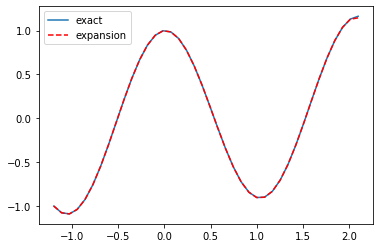

In [15]:
a = -1.2
b = 2.1
max_deg = 10
jp = JacobiPolynomials(alpha=1.5, beta=.5, a=a, b=b, max_degree=max_deg)
x, w, hm = jp.quad_points_weights()
print(len(x))
f = lambda x: np.cos(3*x) + .2*np.sin(x/2.2)
fn = jp.get_coeffs(f(x))

xx = np.linspace(a, b, 40)
pm = jp.get_polys(xx)
f_approx = pm.dot(fn)

plt.plot(xx, f(xx), label='exact')
plt.plot(xx, f_approx, '--r', label='expansion')
plt.legend()
plt.show()

## Derivatives

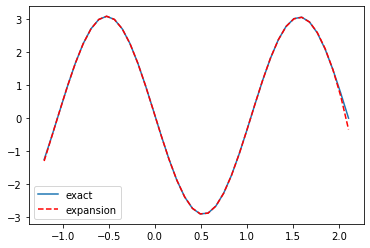

In [16]:
a = -1.2
b = 2.1
max_deg = 10
jp = JacobiPolynomials(alpha=1.5, beta=.5, a=a, b=b, max_degree=max_deg)
x, w, hm = jp.quad_points_weights()
f = lambda x: np.cos(3*x) + .2*np.sin(x/2.2)
df = lambda x: -3*np.sin(3*x) + np.cos(x/2.2)/11

fn = jp.get_coeffs(f(x))
xx = np.linspace(a, b, 40)
df_approx = jp.get_derivatives(xx).dot(fn)

plt.plot(xx, df(xx), label='exact')
plt.plot(xx, df_approx, '--r', label='expansion')
plt.legend()
plt.show()

## Solve an ODE
\begin{align}
&\dot y(t) + g(t)y(t) = f(t),\\
& y(t) = \sum_{n=0}^Na_nP_n^{(\alpha,\beta)}(t),\\
& \dot y(t) = \frac12\sum_{n=0}^{N-1}a_{n+1}(n + \alpha + \beta + 2)P_{n}^{(\alpha+1,\beta+1)}(t)
\end{align}

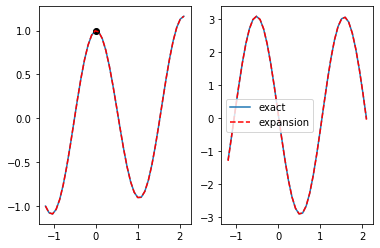

In [17]:
max_deg = 10
alp = -.5
bet = -.5
a = -1.2
b = 2.1
y = lambda x : np.cos(3*x) + .2*np.sin(x/2.2)
f = lambda x: -3*np.sin(3*x) + np.cos(x/2.2)/11
y0 = y(0)

# inner product with expansion of derivatives
jp = JacobiPolynomials(alpha=alp, beta=bet, a=a, b=b, max_degree=3*max_deg)
djp, factors = jp.get_derivatives_factors()
factors = factors[:max_deg]
x, w, hm = djp.quad_points_weights()
ip = djp.get_inner_product_matrix()[:max_deg]

# make matrix
mat = np.zeros((max_deg + 1, max_deg + 1))
mat[:max_deg, 1:] += np.diag(factors)
mat[-1] = jp.get_polys(np.array([0]))[:, :max_deg + 1]

# make RHS vector
vec = np.zeros((max_deg + 1,))
vec[:max_deg] =ip.dot(f(x))
vec[-1] = y0
an = np.linalg.inv(mat).dot(vec)

# check by plotting
xx = np.linspace(a, b, 40)
y_approx = jp.get_polys(xx)[:,:max_deg + 1].dot(an)
dy_approx = jp.get_derivatives(xx)[:,:max_deg + 1].dot(an)

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(xx, y(xx), label='exact')
ax1.plot(0, y0, 'ok')
ax1.plot(xx, y_approx, '--r', label='expansion')
ax2.plot(xx, f(xx), label='exact')
ax2.plot(xx, dy_approx, '--r', label='expansion')
ax2.legend()
plt.show()

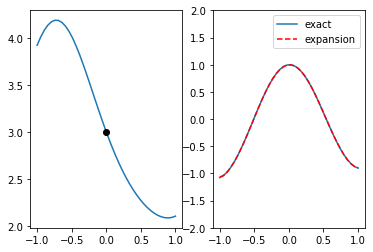

In [18]:
max_deg = 10
alp = -.5
bet = -.5
a = -1
b = 1
f = lambda x : np.cos(3*x) + .2*np.sin(x/2.2)
g = lambda x : np.cos(2.3*x) + .1*np.sin(x/1.2)
y0 = 3

# inner product with expansion of derivatives
jp = JacobiPolynomials(alpha=alp, beta=bet, a=a, b=b, max_degree=3*max_deg)
djp, factors = jp.get_derivatives_factors()
factors = factors[:max_deg]
x, w, hm = djp.quad_points_weights()
ip = djp.get_inner_product_matrix()[:max_deg]

# make matrix
mat = np.zeros((max_deg + 1, max_deg + 1))
mat[:max_deg, 1:] += np.diag(factors)
mat[:max_deg] += ip.dot(np.diag(g(x))).dot(jp.get_polys(x)[:, :max_deg + 1])
mat[-1] = jp.get_polys(np.array([0]))[:, :max_deg + 1]

# make RHS vector
vec = np.zeros((max_deg + 1,))
vec[:max_deg] =ip.dot(f(x))
vec[-1] = y0
an = np.linalg.inv(mat).dot(vec)

# check by plotting
xx = np.linspace(a, b, 40)
y_approx = jp.get_polys(xx)[:,:max_deg + 1].dot(an)
dy_approx = jp.get_derivatives(xx)[:,:max_deg + 1].dot(an)
f_approx = dy_approx + g(xx)*y_approx
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(xx, y_approx)
ax1.plot(0, y0, 'ok')
ax2.plot(xx, f(xx), label='exact')
ax2.plot(xx, f_approx, '--r', label='expansion')
ax2.legend()
ax2.set_ylim([-2,2])
plt.show()

## Integrals
\begin{align}
I_{m}^{(\alpha,\beta)}(\kappa) 
&= \frac{1}{h_m}\int_{-1}^{1}(1-t)^\alpha(1+t)^\beta 
P^{(\alpha,\beta)}_m(t)\textrm{e}^{-\kappa(1 - t)}\textrm{d}t\\
&= \frac{\textrm{e}^{-2\kappa}}{h_m}\int_{-1}^{1}(1-t)^\alpha(1+t)^\beta 
P^{(\alpha,\beta)}_m(t)\textrm{e}^{\kappa(1 + t)}\textrm{d}t\\
&=
\chi_m\textrm{e}^{-2\kappa}
{}_{1}F_1(\beta+m+1, \alpha+\beta+2m+2, 2\kappa),\\
\chi_m
&= \frac{\Gamma(\alpha+1)\Gamma(\beta+m+1)}
{h_m\Gamma(\alpha+\beta+m+1)}
\kappa^m\textrm{e}^{\alpha+\beta+m+1}\\
&= \kappa^m\textrm{e}^{\alpha+\beta+m+1}
\frac{m!(\alpha+\beta+2m+1)\Gamma(\alpha+1)}
{2^{\alpha+\beta+1}\Gamma(\alpha+m+1)}.
\end{align}

The coefficients $\chi_m$ can be calculated with the following recursion relation:
\begin{align}
\chi_0
&= \frac{\Gamma(\alpha+1)\Gamma(\beta+1)}{\Gamma(\alpha+\beta+1)}
\textrm{e}^{\alpha+\beta+1},\\
\chi_m
&= 
\frac{(\alpha+\beta+2m+1)(m\kappa\textrm{e})}{(\alpha+\beta+2m-1)(\alpha+m)}
\chi_{m-1}.
\end{align}

This comes from https://functions.wolfram.com/Polynomials/JacobiP/21/02/01/0003/.
Here, $_1F_1$ is the confluent geometric function, defined here: https://dlmf.nist.gov/13, with asymptotic expansion for large $\kappa$ here: https://dlmf.nist.gov/13.7. It is implemented as https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.hyp1f1.html.

\begin{align}
J_{m}^{(\alpha,\beta)}(\kappa) 
&= \frac{1}{h_m}
\int_{-1}^{1}(1-t)^\alpha(1+t)^\beta P^{(\alpha,\beta)}_m(t)\textrm{e}^{-\kappa(1 + t)}\textrm{d}t\\
&= \frac{1}{h_m}
\int_{-1}^{1}(1+t)^\alpha(1-t)^\beta P^{(\alpha,\beta)}_m(-t)\textrm{e}^{-\kappa(1 - t)}\textrm{d}t\\
&= \frac{(-1)^m}{h_m}\int_{-1}^{1}(1+t)^\alpha(1-t)^\beta P^{(\beta,\alpha)}_m(t)\textrm{e}^{-\kappa(1 - t)}\textrm{d}t\\
&= (-1)^mI_m^{\beta,\alpha}(\kappa)
\end{align}

We can use these to give some results for arbitrary intervals:
\begin{align}
\hat I_{m}^{(\alpha,\beta)}(\kappa,a,b)
&= \frac{1}{h_m}\left(\frac{2}{b-a}\right)^{\alpha+\beta+1}
\int_{a}^{b}(b-z)^\alpha(z-a)^\beta P_m(t)\textrm{e}^{-\kappa(b - z)}\textrm{d}z\\
&= \frac{1}{h_m}
\int_{-1}^{1}(1-t)^\alpha(1+t)^\beta P_m(t)\textrm{e}^{-(b-a)\kappa(1 -t)/2}\textrm{d}t\\
&=
I_{m}^{(\alpha,\beta)}\big(\kappa(b-a)/2\big),\\
z-a&=\frac{b-a}2(1+t),\\
b-z&=\frac{b-a}2(1-t).
\end{align}

Also
\begin{align}
\hat J_{m}^{(\alpha,\beta)}(\kappa,a,b) 
&= \frac{1}{h_m}\left(\frac{2}{b-a}\right)^{\alpha+\beta+1}
\int_{a}^{b}(b-z)^\alpha(z-a)^\beta P_m(t)\textrm{e}^{-\kappa(z-a)}\textrm{d}z\\
&=\frac{1}{h_m} 
\int_{-1}^{1}(1-t)^\alpha(1+t)^\beta P_m(t)\textrm{e}^{-(b-a)\kappa(1 + t)/2}\textrm{d}t\\
&=
J_{m}^{(\alpha,\beta)}\big(\kappa(b-a)/2\big).
\end{align}

Finally, we can get
\begin{align}
\hat K_{m}^{(\alpha,\beta)}(\kappa,a,b) 
&= \frac{2^{\alpha+\beta+1}}{h_m(b-a)^{\alpha+\beta+1}}
\int_{a}^{b}(b-z)^\alpha(z-a)^\beta P_m(t)\frac{\cosh\kappa(z+h)}{\cosh(\kappa h)}\textrm{d}z\\
&= \frac{\textrm{e}^{\kappa b}}{1+\textrm{e}^{-2\kappa h}}
\hat I_{m}^{(\alpha,\beta)}(\kappa,a,b)
+
\frac{\textrm{e}^{-\kappa(2h+a)}}{1+\textrm{e}^{-2\kappa h}}
\hat J_{m}^{(\alpha,\beta)}(\kappa,a,b)\\
&=\frac{\textrm{e}^{\kappa b}}{1+\textrm{e}^{-2\kappa h}}
I_{m}^{(\alpha,\beta)}\big(\kappa(b-a)/2\big)
+
\frac{\textrm{e}^{-\kappa(2h+a)}}{1+\textrm{e}^{-2\kappa h}}
J_{m}^{(\alpha,\beta)}\big(\kappa(b-a)/2\big)
\end{align}

In [19]:
def inprod_with_exp(jp, kappa):
    twh = jp.quad_points_weights()
    t, w, h = twh
    f = np.exp(-(1-t.reshape(-1,1)).dot(kappa)) # t in rows, kappa in cols
    ipm = jp.get_inner_product_matrix(xwh=twh)
    return ipm.dot(f)

In [20]:
def inprod_with_exp_hyp1f1(jp, kappa):
    fn = np.zeros((jp.max_degree, np.max(kappa.shape)), dtype=np.complex)
    ab1 = jp.alpha + jp.beta + 1
    chi0 = gamma(jp.alpha+1)*gamma(jp.beta+1)*np.exp(ab1)/gamma(ab1)
    for m in range(jp.max_degree):
        chi = chi0 * m * kappa * np.exp(1) * (ab1 + 2*m)/((ab1+2*(m-1))*(jp.alpha+m))
        chi0 = chi
        print(fn.shape)
        fn[m] = chi * np.exp(-2*kappa) * hyp1f1(jp.beta+m+1, jp.alpha + jp.beta+2*(m+1), 2*kappa)
    return fn

In [21]:
jp = JacobiPolynomials(a=-1, b=1)

In [22]:
kappa = np.linspace(0.1, 3, 10).reshape(1,-1)

In [23]:
fn = inprod_with_exp(jp, kappa)
fn

array([[9.06346235e-01, 6.75241499e-01, 5.20103815e-01, 4.13230393e-01,
        3.37616451e-01, 2.82670182e-01, 2.41688260e-01, 2.10354882e-01,
        1.85840319e-01, 1.66253541e-01],
       [9.05742579e-02, 2.81770115e-01, 3.73598554e-01, 4.10598343e-01,
        4.17899111e-01, 4.09645628e-01, 3.93755819e-01, 3.74615457e-01,
        3.54608145e-01, 3.34985835e-01],
       [3.01827970e-03, 3.94561320e-02, 9.12750541e-02, 1.41472232e-01,
        1.83645457e-01, 2.16334465e-01, 2.40189288e-01, 2.56600092e-01,
        2.67070205e-01, 2.72957981e-01],
       [6.03560146e-05, 3.32246641e-03, 1.34719884e-02, 2.96512789e-02,
        4.95248221e-02, 7.08351705e-02, 9.18824200e-02, 1.11564724e-01,
        1.29268673e-01, 1.44731651e-01],
       [8.62141698e-07, 2.00042962e-04, 1.42479007e-03, 4.46735113e-03,
        9.64097576e-03, 1.68274382e-02, 2.56480387e-02, 3.56187109e-02,
        4.62548688e-02, 5.71293373e-02],
       [9.57868278e-09, 9.37305726e-06, 1.17399309e-04, 5.25308331e-04,
   

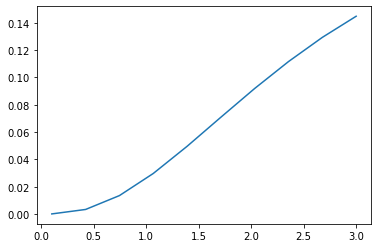

In [24]:
plt.plot(kappa[0], fn[3])

In [25]:
fn2 = inprod_with_exp_hyp1f1(jp, kappa)

(7, 10)
(7, 10)
(7, 10)
(7, 10)
(7, 10)
(7, 10)
(7, 10)


/home/timill/Packages/python/miniconda2/envs/pywave/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [26]:
fn2

array([[nan+0.j, nan+0.j, nan+0.j, nan+0.j, nan+0.j, nan+0.j, nan+0.j,
        nan+0.j, nan+0.j, nan+0.j],
       [nan+0.j, nan+0.j, nan+0.j, nan+0.j, nan+0.j, nan+0.j, nan+0.j,
        nan+0.j, nan+0.j, nan+0.j],
       [nan+0.j, nan+0.j, nan+0.j, nan+0.j, nan+0.j, nan+0.j, nan+0.j,
        nan+0.j, nan+0.j, nan+0.j],
       [nan+0.j, nan+0.j, nan+0.j, nan+0.j, nan+0.j, nan+0.j, nan+0.j,
        nan+0.j, nan+0.j, nan+0.j],
       [nan+0.j, nan+0.j, nan+0.j, nan+0.j, nan+0.j, nan+0.j, nan+0.j,
        nan+0.j, nan+0.j, nan+0.j],
       [nan+0.j, nan+0.j, nan+0.j, nan+0.j, nan+0.j, nan+0.j, nan+0.j,
        nan+0.j, nan+0.j, nan+0.j],
       [nan+0.j, nan+0.j, nan+0.j, nan+0.j, nan+0.j, nan+0.j, nan+0.j,
        nan+0.j, nan+0.j, nan+0.j]])